# Predicting Nigeria House Prices (Lagos & Abuja)


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from ydata_profiling import ProfileReport
from ipywidgets import Dropdown, IntSlider, interact
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-deep')
plt.rcParams["figure.figsize"] = (12,5)

#### Importing data (csv) into Pandas dataframe

In [2]:
df = pd.read_csv("nigeria_houses_data.csv")
print(df.shape)
df.head()

(24326, 8)


,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


There are no missing values in the dataset.

##### Summary Statistics of all features

In [4]:
df.describe(include="all")

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
count,24326.000000,24326.000000,24326.000000,24326.000000,24326,24326,24326,2.432600e+04
unique,NaN,NaN,NaN,NaN,7,189,25,NaN
top,NaN,NaN,NaN,NaN,Detached Duplex,Lekki,Lagos,NaN
freq,NaN,NaN,NaN,NaN,13992,10895,18445,NaN
mean,4.338814,4.600798,5.176355,4.041725,NaN,NaN,NaN,3.013802e+08
std,1.138497,1.163161,1.226253,1.399936,NaN,NaN,NaN,1.220403e+10
min,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,9.000000e+04
25%,4.000000,4.000000,5.000000,4.000000,NaN,NaN,NaN,5.200000e+07
50%,4.000000,5.000000,5.000000,4.000000,NaN,NaN,NaN,8.500000e+07
75%,5.000000,5.000000,6.000000,4.000000,NaN,NaN,NaN,1.600000e+08


The summary statistics shows that:
- The maximum `bedrooms`, `bathrooms`, `parking_space` and `toilets` are 9.
- There are 25 `states` in the dataset.
- There are 7 unique `title` in the dataset.
- There are 189 `town` in the dataset.
- The highest apartment `price` is `1,800,000,000,000` naira.
- The lowest apartment `price` is `90,000`

In [5]:
#checking the unique towns in each states
list_state = df.state.unique()

for state in list_state:
    town_list = df[df["state"]==state].groupby("town")["price"].mean().index.to_list()
    print(f"{state}: {town_list}\n")

Abuja: ['Apo', 'Asokoro District', 'Bwari', 'Central Business District', 'Dakibiyu', 'Dakwo', 'Dape', 'Dei-Dei', 'Diplomatic Zones', 'Duboyi', 'Durumi', 'Dutse', 'Gaduwa', 'Galadimawa', 'Garki', 'Gudu', 'Guzape District', 'Gwagwalada', 'Gwarinpa', 'Idu Industrial', 'Jabi', 'Jahi', 'Jikwoyi', 'Kabusa', 'Kado', 'Kafe', 'Kagini', 'Karmo', 'Karsana', 'Karshi', 'Karu', 'Katampe', 'Kaura', 'Kubwa', 'Kuje', 'Kukwaba', 'Kurudu', 'Kyami', 'Life Camp', 'Lokogoma District', 'Lugbe District', 'Mabushi', 'Maitama District', 'Mararaba', 'Mbora (Nbora)', 'Mpape', 'Nyanya', 'Orozo', 'Utako', 'Wumba', 'Wuse', 'Wuse 2', 'Wuye']

Lagos: ['Agbara-Igbesa', 'Agege', 'Ajah', 'Alimosho', 'Amuwo Odofin', 'Apapa', 'Ayobo', 'Badagry', 'Egbe', 'Ejigbo', 'Eko Atlantic City', 'Epe', 'Gbagada', 'Ibeju', 'Ibeju Lekki', 'Idimu', 'Ifako-Ijaiye', 'Ijaiye', 'Ijede', 'Ijesha', 'Ikeja', 'Ikorodu', 'Ikotun', 'Ikoyi', 'Ilupeju', 'Imota', 'Ipaja', 'Isheri', 'Isheri North', 'Isolo', 'Ketu', 'Kosofe', 'Lagos Island', 'Lekki', '

Some towns in other states are wrongly assigned to Anambra State.
- *Imo* = [ 'Owerri Municipal']
- *Rivers* = ['Port Harcourt']
- *Lagos* = ['Agege', 'Ajah','Alimosho','Gbagada','Ibeju Lekki', 'Ifako-Ijaiye', 'Ikeja', 'Ikorodu', 'Ikotun', 'Ikoyi', 'Ketu', 'Lekki','Ojo', 'Shomolu', 'Victoria Island (VI)', 'Yaba']
- *Ogun* = ['Arepo', 'Mbora (Nbora)', 'Mowe Ofada', 'Magboro', 'Mowe Town']
- *Kwara* = ['Jabi']
- *Oyo* = [ 'Ibadan']
-*Ondo* = [ 'Akure']
- *Abuja* = ['Guzape District', 'Gwarinpa', 'Katampe', 'Lokogoma District']
- *Nasarawa* = ['Karu']

Lets define a function `reassign_town` to reassign the towns to their corresponding states.

In [6]:
#list of the town and their corresponding states
imo_town_in_anambra = [ 'Owerri Municipal']
river_town_in_anambra = ['Port Harcourt']
lagos_town_in_anambra = ['Agege', 'Ajah','Alimosho','Gbagada','Ibeju Lekki', 'Ifako-Ijaiye', 'Ikeja', 'Ikorodu', 'Ikotun', 'Ikoyi',
                         'Ketu', 'Lekki', 'Ojo', 'Shomolu', 'Victoria Island (VI)', 'Yaba']
ogun_town_in_anambra = ['Arepo', 'Mbora (Nbora)', 'Mowe Ofada', 'Magboro', 'Mowe Town']
kwara_town_in_anambra = ['Jabi']
oyo_town_in_anambra = [ 'Ibadan']
ondo_town_in_anambra = [ 'Akure']
abuja_town_in_anambra = ['Guzape District', 'Gwarinpa', 'Katampe', 'Lokogoma District']
nasarawa_town_in_anambra = ['Karu']

dict_anambra = {"Lagos":lagos_town_in_anambra, "Rivers": river_town_in_anambra, "Imo":imo_town_in_anambra, "Ogun": ogun_town_in_anambra,
         "Kwara": kwara_town_in_anambra, "Oyo": oyo_town_in_anambra, "Ondo": ondo_town_in_anambra, "Abuja":abuja_town_in_anambra,
         "Nasarawa": nasarawa_town_in_anambra}

#defining the function that reassigns the towns to their corresponding states
def reassign_town(dict_state, state):
    for each_state, list_towns in dict_state.items():
        index = []
        for i in df.index:
            each_df_row = df.loc[i,:]
            if (each_df_row["town"] in list_towns) and (each_df_row["state"] == state):
                index.append(i)
        df.loc[index,"state"] = df.loc[index,"state"].replace({state:each_state})


reassign_town(dict_anambra, "Anambara")

#checking the unique towns in each states
list_state = df.state.unique()

for state in list_state:
    town_list = df[df["state"]==state].groupby("town")["price"].mean().index.to_list()
    print(f"{state}: {town_list}\n")

Abuja: ['Apo', 'Asokoro District', 'Bwari', 'Central Business District', 'Dakibiyu', 'Dakwo', 'Dape', 'Dei-Dei', 'Diplomatic Zones', 'Duboyi', 'Durumi', 'Dutse', 'Gaduwa', 'Galadimawa', 'Garki', 'Gudu', 'Guzape District', 'Gwagwalada', 'Gwarinpa', 'Idu Industrial', 'Jabi', 'Jahi', 'Jikwoyi', 'Kabusa', 'Kado', 'Kafe', 'Kagini', 'Karmo', 'Karsana', 'Karshi', 'Karu', 'Katampe', 'Kaura', 'Kubwa', 'Kuje', 'Kukwaba', 'Kurudu', 'Kyami', 'Life Camp', 'Lokogoma District', 'Lugbe District', 'Mabushi', 'Maitama District', 'Mararaba', 'Mbora (Nbora)', 'Mpape', 'Nyanya', 'Orozo', 'Utako', 'Wumba', 'Wuse', 'Wuse 2', 'Wuye']

Lagos: ['Agbara-Igbesa', 'Agege', 'Ajah', 'Alimosho', 'Amuwo Odofin', 'Apapa', 'Ayobo', 'Badagry', 'Egbe', 'Ejigbo', 'Eko Atlantic City', 'Epe', 'Gbagada', 'Ibeju', 'Ibeju Lekki', 'Idimu', 'Ifako-Ijaiye', 'Ijaiye', 'Ijede', 'Ijesha', 'Ikeja', 'Ikorodu', 'Ikotun', 'Ikoyi', 'Ilupeju', 'Imota', 'Ipaja', 'Isheri', 'Isheri North', 'Isolo', 'Ketu', 'Kosofe', 'Lagos Island', 'Lekki', '

In [7]:
print(df.state.unique())
df.info()

['Abuja' 'Lagos' 'Edo' 'Ogun' 'Oyo' 'Imo' 'Rivers' 'Enugu' 'Kaduna'
 'Kwara' 'Nasarawa' 'Abia' 'Delta' 'Akwa Ibom' 'Osun' 'Ekiti'
 'Cross River' 'Kogi' 'Plateau' 'Ondo' 'Kano' 'Katsina' 'Bayelsa' 'Borno'
 'Niger']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


The function works well, no missing data and now `Kwara` has `Jabi`as one of its towns.

#### Duplicated Rows

In [8]:
# How many duplicates are there in the dataset
print(f"There are {df.duplicated().sum()} duplicated rows in the dataset")


print(f"Shape with duplicates: {df.shape}")

# Removing duplicates
df_dup = df.copy().drop_duplicates()
print(f"Shape without duplicates: {df_dup.shape}")

There are 10558 duplicated rows in the dataset
Shape with duplicates: (24326, 8)
Shape without duplicates: (13768, 8)


#### Exploring outliers: Bedrooms vs Toilets

In [9]:
# apartments with less than 4 bedrooms with 9 toilets
df_dup[(df_dup['toilets'] == 9) & (df_dup["bedrooms"] < 4) ].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
126,2.0,5.0,9.0,4.0,Detached Bungalow,Ibeju Lekki,Lagos,3.000000e+07
5574,3.0,9.0,9.0,6.0,Block of Flats,Agege,Lagos,3.500000e+07
6566,1.0,8.0,9.0,4.0,Detached Duplex,Victoria Island (VI),Lagos,1.400000e+09
9163,1.0,9.0,9.0,4.0,Detached Bungalow,Oredo,Edo,3.500000e+07
13501,1.0,9.0,9.0,4.0,Block of Flats,Ibadan,Oyo,1.800000e+07


An housing apartment with 3 or less bedrooms having 9 toilets is too extreme.

In [10]:
# dropping these extreme rows [126, 5574, 6566, 9163, 13501, 14846, 18542, 22614, 23141]
df_dup.drop(df_dup[(df_dup['toilets'] == 9) & (df_dup["bedrooms"] < 4)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13759, 8)

In [11]:
# apartments with less than 4 bedrooms with 8 toilets
df_dup[(df_dup['toilets'] == 8) & (df_dup["bedrooms"] < 3) ].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
2525,2.0,8.0,8.0,4.0,Block of Flats,Ajah,Lagos,45000000.0
4169,1.0,9.0,8.0,1.0,Detached Duplex,Ibadan,Oyo,120000000.0
4176,2.0,7.0,8.0,7.0,Detached Duplex,Jos South,Plateau,500000.0
13626,1.0,6.0,8.0,4.0,Detached Bungalow,Ikorodu,Lagos,45000000.0
14047,1.0,8.0,8.0,6.0,Semi Detached Duplex,Enugu,Enugu,40000000.0


In [12]:
# dropping these extreme rows [ 2525,  4169,  4176, 13626, 14047, 14263, 14675, 15333, 15965, 16971, 18217, 20737, 20947, 21264]
df_dup.drop(df_dup[(df_dup['toilets'] == 8) & (df_dup["bedrooms"] < 3) ].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13746, 8)

In [13]:
# apartments with less than 4 bedrooms with 8 toilets
df[(df['toilets'] == 7) & (df["bedrooms"] < 3) ].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
14917,1.0,7.0,7.0,1.0,Terraced Bungalow,Alimosho,Lagos,80000000.0


In [14]:
# dropping this extreme row 14917
df_dup.drop(df_dup[(df_dup['toilets'] ==7) & (df_dup["bedrooms"] < 3) ].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13745, 8)

In [15]:
# apartments with less than 4 bedrooms with 8 toilets
df_dup[(df_dup['toilets'] == 6) & (df_dup["bedrooms"] < 2)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
7287,1.0,6.0,6.0,7.0,Detached Duplex,Lugbe District,Abuja,38000000.0


In [16]:
# dropping this extreme row 7287
df_dup.drop(df_dup[(df_dup['toilets'] == 6) & (df_dup["bedrooms"] < 2) ].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13744, 8)

In [17]:
# apartments with 9 bedrooms having less than 4 toilets
df_dup[(df_dup['bedrooms'] == 9) & (df_dup["toilets"] < 4)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
183,9.0,9.0,1.0,1.0,Detached Duplex,Isolo,Lagos,70000000.0
366,9.0,9.0,1.0,8.0,Detached Duplex,Lekki,Lagos,250000000.0
648,9.0,9.0,1.0,1.0,Detached Duplex,Maitama District,Abuja,700000000.0
728,9.0,9.0,1.0,4.0,Detached Duplex,Surulere,Lagos,95000000.0
930,9.0,9.0,1.0,4.0,Detached Duplex,Lekki,Lagos,320000000.0


These records are extreme. An housing apartments with 9 `bedrooms` but having less than 4 toilets?!

In [18]:
# dropping these extreme rows
df_dup.drop(df_dup[(df_dup['bedrooms'] == 9) & (df_dup["toilets"] < 4)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13689, 8)

In [19]:
# apartments with 8 bedrooms having less than 3 toilets
df_dup[(df_dup['bedrooms'] == 8) & (df_dup["toilets"] <3)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
139,8.0,1.0,1.0,4.0,Detached Duplex,Ibadan,Oyo,1.500000e+08
449,8.0,1.0,1.0,4.0,Detached Duplex,Asokoro District,Abuja,7.500000e+08
633,8.0,1.0,1.0,7.0,Detached Duplex,Maitama District,Abuja,8.500000e+08
1940,8.0,8.0,1.0,1.0,Detached Duplex,Maitama District,Abuja,1.100000e+09
1955,8.0,2.0,2.0,4.0,Block of Flats,Ibadan,Oyo,6.000000e+06


In [20]:
# dropping these extreme rows
df_dup.drop(df_dup[(df_dup['bedrooms'] == 8) & (df_dup["toilets"] < 4)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13650, 8)

In [21]:
# apartments with 7 bedrooms having less than 3 toilets
df_dup[(df_dup['bedrooms'] == 7) & (df_dup["toilets"] <3)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
1013,7.0,7.0,1.0,6.0,Detached Duplex,Ojo,Lagos,2.500000e+07
3059,7.0,7.0,1.0,4.0,Detached Duplex,Maitama District,Abuja,1.200000e+09
4193,7.0,7.0,1.0,1.0,Detached Duplex,Ikeja,Lagos,7.000000e+08
6706,7.0,9.0,1.0,1.0,Detached Duplex,Ikoyi,Lagos,1.000000e+09
7076,7.0,5.0,1.0,2.0,Detached Duplex,Lekki,Lagos,2.700000e+08


In [22]:
# dropping these extreme rows
df_dup.drop(df_dup[(df_dup['bedrooms'] == 7) & (df_dup["toilets"] < 3)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13634, 8)

In [23]:
# apartments with 6 bedrooms having less than 3 toilets
df_dup[(df_dup['bedrooms'] == 6) & (df_dup["toilets"] <3)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
5035,6.0,1.0,1.0,5.0,Detached Duplex,Isheri North,Lagos,140000000.0
5297,6.0,1.0,1.0,1.0,Detached Duplex,Gwarinpa,Abuja,120000000.0
5615,6.0,1.0,1.0,1.0,Detached Duplex,Ikeja,Lagos,490000000.0
5796,6.0,2.0,2.0,6.0,Detached Bungalow,Idimu,Lagos,10000000.0
8304,6.0,2.0,2.0,8.0,Detached Bungalow,Alimosho,Lagos,15000000.0


In [24]:
# dropping these extreme rows
df_dup.drop(df_dup[(df_dup['bedrooms'] == 6) & (df_dup["toilets"] < 3)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13619, 8)

#### Exploring outliers: Bedrooms vs Bathrooms

In [25]:
df_dup[(df_dup['bathrooms'] == 8) & (df_dup["bedrooms"] < 3)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
9786,1.0,8.0,1.0,6.0,Block of Flats,Ijaiye,Lagos,45000000.0


This is too extreme!

In [26]:
# dropping this extreme row 9786
df_dup.drop(df_dup[(df_dup['bathrooms'] == 8) & (df_dup["bedrooms"] < 3)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13618, 8)

In [27]:
# apartments with 9 bedrooms having less than 4 bathrooms
df_dup[(df_dup['bedrooms'] == 9) & (df_dup["bathrooms"] < 4)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
8592,9.0,3.0,6.0,4.0,Detached Duplex,Ajah,Lagos,200000000.0
23393,9.0,1.0,9.0,9.0,Detached Duplex,Ojo,Lagos,50000000.0


In [28]:
# dropping these extreme rows
df_dup.drop(df_dup[(df_dup['bedrooms'] == 9) & (df_dup["bathrooms"] < 4)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13616, 8)

In [29]:
# apartments with 8 bedrooms having less than 4 bathrooms
df_dup[(df_dup['bedrooms'] == 8) & (df_dup["bathrooms"] < 4)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
11269,8.0,2.0,4.0,4.0,Block of Flats,Ado-Odo/Ota,Ogun,12000000.0


In [30]:
# dropping this extreme row
df_dup.drop(df_dup[(df_dup['bedrooms'] == 8) & (df_dup["bathrooms"] < 4)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13615, 8)

In [31]:
# apartments with 7 bedrooms having less than 3 bathrooms
df_dup[(df_dup['bedrooms'] == 7) & (df_dup["bathrooms"] < 3)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
17628,7.0,1.0,8.0,1.0,Detached Duplex,Asokoro District,Abuja,450000000.0


In [32]:
# dropping this extreme row
df_dup.drop(df_dup[(df_dup['bedrooms'] == 7) & (df_dup["bathrooms"] < 3)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13614, 8)

In [33]:
# apartments with 6 bedrooms having less than 3 bathrooms
df_dup[(df_dup['bedrooms'] == 6) & (df_dup["bathrooms"] < 3)].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
2798,6.0,1.0,9.0,1.0,Detached Duplex,Asokoro District,Abuja,350000000.0
12055,6.0,2.0,3.0,2.0,Detached Bungalow,Kuje,Abuja,12000000.0
21129,6.0,2.0,6.0,4.0,Semi Detached Bungalow,Ikorodu,Lagos,16000000.0
22086,6.0,2.0,4.0,1.0,Block of Flats,Ifo,Ogun,30000000.0


In [34]:
# dropping these extreme rows
df_dup.drop(df_dup[(df_dup['bedrooms'] == 6) & (df_dup["bathrooms"] < 3)].index.to_list(), axis=0, inplace=True)
df_dup.shape

(13610, 8)

In [35]:
# apartments where bathrooms > 6 and toilets < 3 or bathrooms < 3 and toilets > 6
df_dup[((df_dup['bathrooms'] > 6) & (df_dup["toilets"] < 3)) | ((df_dup['bathrooms'] < 3) & (df_dup["toilets"] > 6))].head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
9627,4.0,8.0,1.0,7.0,Detached Duplex,Maryland,Lagos,150000000.0
16728,5.0,9.0,1.0,1.0,Detached Duplex,Galadimawa,Abuja,200000000.0
16860,5.0,1.0,9.0,4.0,Detached Duplex,Ikorodu,Lagos,40000000.0
17601,3.0,8.0,1.0,6.0,Block of Flats,Ojo,Lagos,28000000.0
22991,4.0,8.0,1.0,4.0,Detached Duplex,Wuse 2,Abuja,350000000.0


In [36]:
# dropping these extreme rows
df_dup.drop(df_dup[((df_dup['bathrooms'] > 6) & (df_dup["toilets"] < 3)) | ((df_dup['bathrooms'] < 3) & (df_dup["toilets"] > 6))].index.to_list(),
        inplace=True, axis=0)
df_dup.shape

(13604, 8)

#### Exploring outliers: Apartment Features vs Price

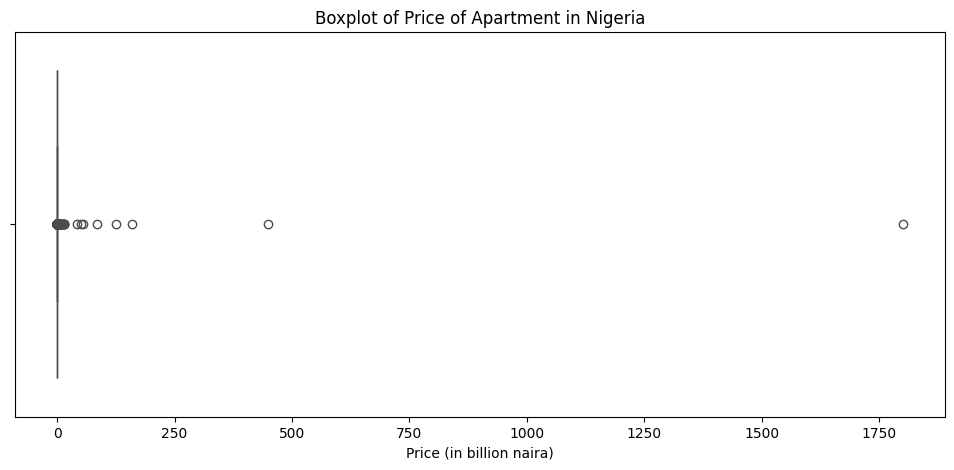

In [37]:
sns.boxplot(x=df_dup["price"]/1e9, orient="h")
plt.xlabel("Price (in billion naira)")
plt.title("Boxplot of Price of Apartment in Nigeria");

In [38]:
#The apartment with the minimum price
df_dup[df_dup["price"] == df_dup["price"].min()]

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
2693,2.0,3.0,3.0,4.0,Terraced Duplexes,Ibeju Lekki,Lagos,90000.0


- The boxplot shows that there are outliers in `price`.
- Also, looking at the minimum amount, it shows that the cheatest apartment price of a two-bedroom apartment in Ibeju-Lekki is`90,000` naira.

In [39]:
# Removing outliers in price (prices below or above the 10th and 90th percentile respectively)

low, high = df_dup["price"].quantile([0.1,0.9])
mask = df_dup["price"].between(low, high)
df_dup = df_dup[mask]
df_dup.shape

(10957, 8)

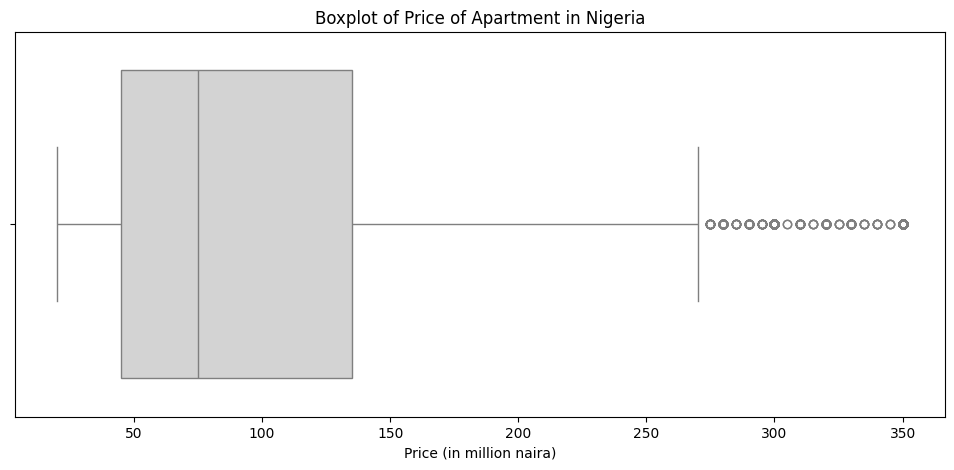

In [40]:
#Boxplot after removing outlier in price feature
sns.boxplot(x=df_dup["price"]/1e6, orient="h", color="lightgray")
plt.xlabel("Price (in million naira)")
plt.title("Boxplot of Price of Apartment in Nigeria");

## Exploring the Features

In [41]:
# Aggregation on state
df_agg = df_dup.groupby("state")["price"].agg(["count", "median", "mean", "std"]).sort_values(ascending=False, by="mean")

# Aggregation with state with more than 10 records
df_agg = df_agg[df_agg["count"] > 10]

df_agg

,count,median,mean,std
state,,,,
Lagos,7002,80000000.0,1.075069e+08,7.936040e+07
Abuja,2529,75000000.0,1.022719e+08,7.548095e+07
Imo,205,60000000.0,7.875610e+07,5.842222e+07
Rivers,383,65000000.0,7.828803e+07,5.468043e+07
Delta,52,50000000.0,7.442308e+07,6.227055e+07
Enugu,115,55000000.0,6.742739e+07,4.637902e+07
Oyo,277,45000000.0,6.088718e+07,4.599639e+07
Edo,78,40000000.0,5.711538e+07,5.085579e+07
Akwa Ibom,19,35000000.0,5.678947e+07,3.712379e+07


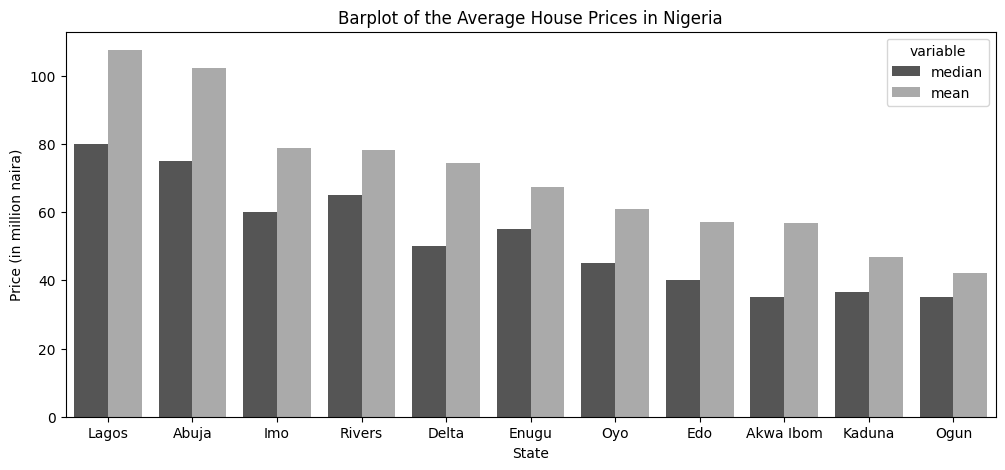

In [42]:
#construct a barplot showing the mean and median house prices for each state.
bar_data = pd.melt(df_agg.reset_index().iloc[:,[0,2,3]], id_vars="state")
sns.barplot(x=bar_data["state"], y=bar_data["value"]/1e6, hue=bar_data["variable"], palette=sns.palettes.color_palette("gray", 2))
plt.xlabel("State")
plt.ylabel("Price (in million naira)")
plt.title("Barplot of the Average House Prices in Nigeria");

The barplot shows that Lagos State have the highest overall mean and median apartment price. Lagos is closely followed by Abuja and Anambara State. The States with the highest average housing price are among the Nigeria states with the most GDP according to [Wikipedia Nigeria GDP by state](https://en.wikipedia.org/wiki/List_of_Nigerian_states_by_GDP).

#### Housing Price: State and Town
Lets construct a barchat showing the town with the highest average house price for the top two states

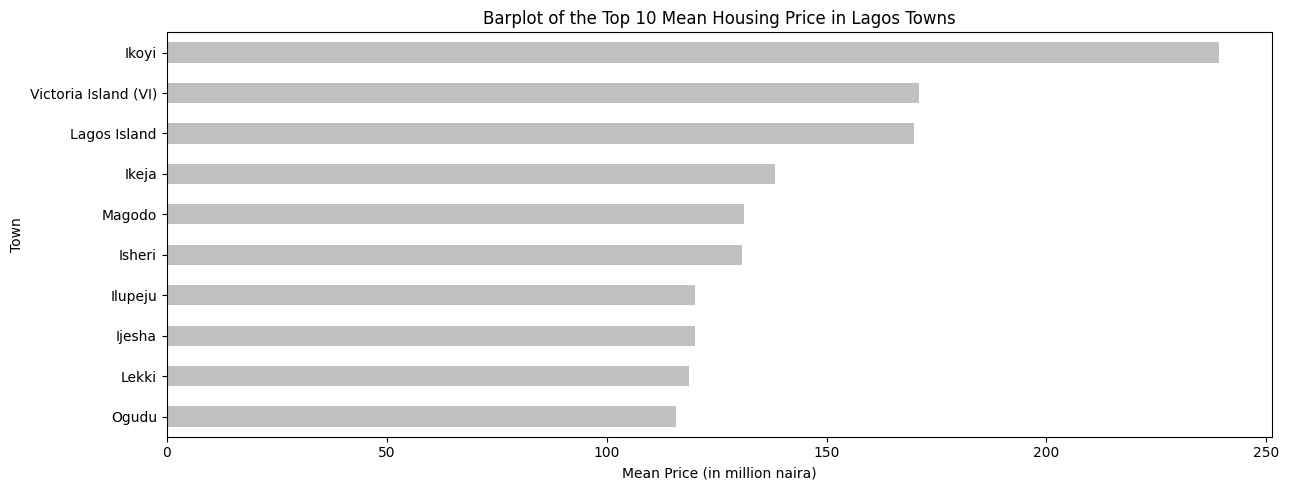

In [43]:
#Mean house price in Lagos State

df_lagos = df_dup[df_dup["state"]=="Lagos"]

fig, ax = plt.subplots(figsize=(13,5))
((df_lagos.groupby(["town"])["price"].mean())/1e6).sort_values().tail(10).plot.barh(ax=ax, ylabel="Town", xlabel="Mean Price (in million naira)",
                                                                           fontsize=10, title="Barplot of the Top 10 Mean Housing Price in Lagos Towns",
                                                                           color="silver")
plt.tight_layout();

Ikoyi have the highest mean apartment price in Lagos state which is roughly `250 million naira`.

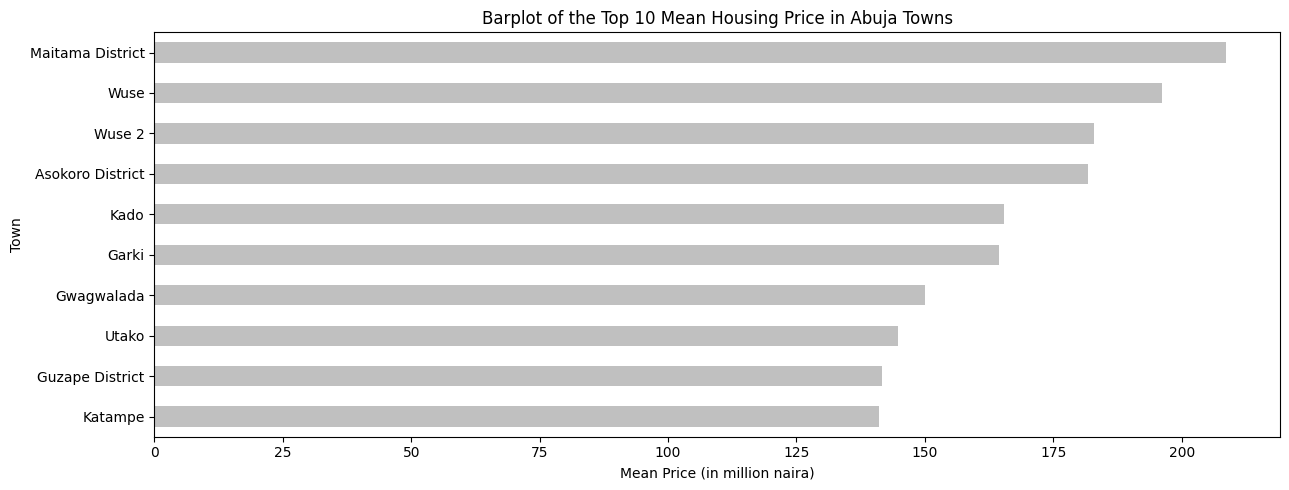

In [44]:
#Mean house price in Abuja FCT
df_abuja = df_dup[df_dup["state"]=="Abuja"]

fig, ax = plt.subplots(figsize=(13,5))
(((df_abuja.groupby(["town"])["price"].mean())/1e6).sort_values().tail(10)
 .plot.barh(ax=ax, ylabel="Town", xlabel="Mean Price (in million naira)",
            fontsize=10, title="Barplot of the Top 10 Mean Housing Price in Abuja Towns",
            color="silver"))
plt.tight_layout();

#### Housing Price: Space and Title

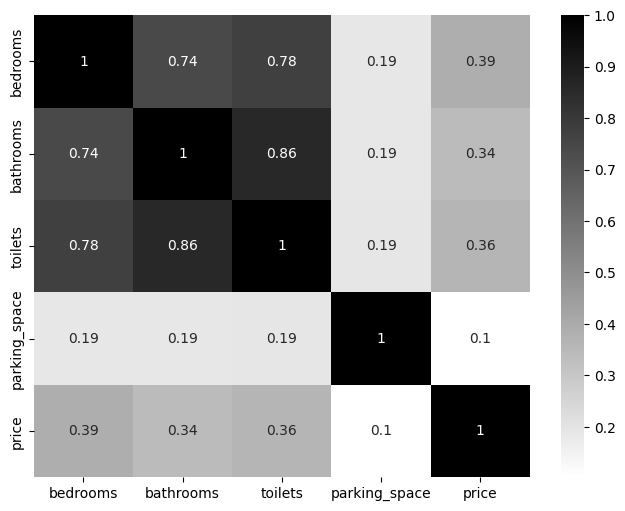

In [45]:
# correlation between space and house price
correlation_matrix = df_dup.select_dtypes("number").corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(correlation_matrix, cmap="gray_r", annot=True);

The heatmap shows that there is a weak positive linear relationship between space and house price. Also, bedrooms, toilets, and bathrooms are highly correlated which is expected.

#### The distribution of housing title

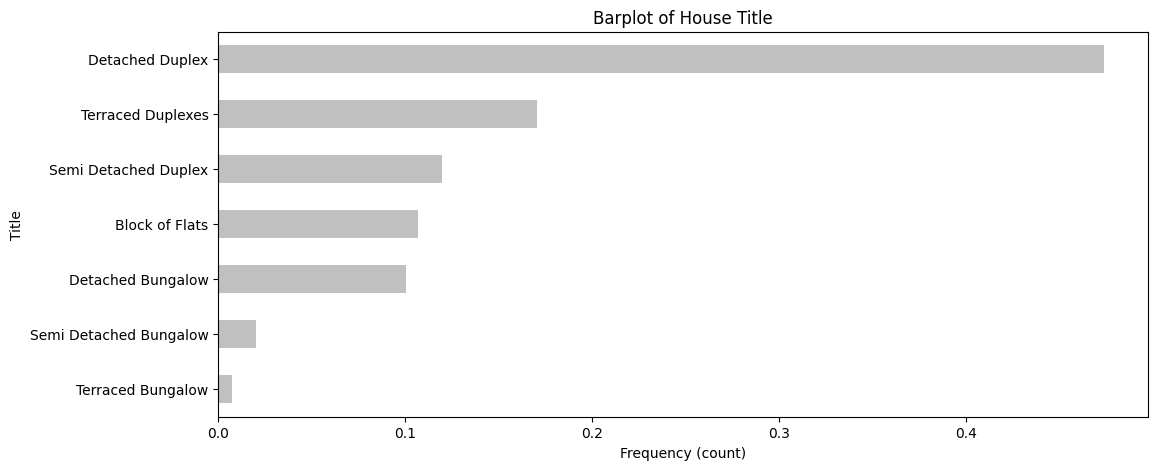

In [46]:
#barplot of the distribution of house title
df_dup["title"].value_counts(normalize=True).sort_values().plot.barh(xlabel="Frequency (count)", color="silver",
                                                                 ylabel="Title", title="Barplot of House Title");

Detached Duplex is the most frequent housing title in the dataset, accounting for approximately `60%` of the dataset.

#### House title and house price

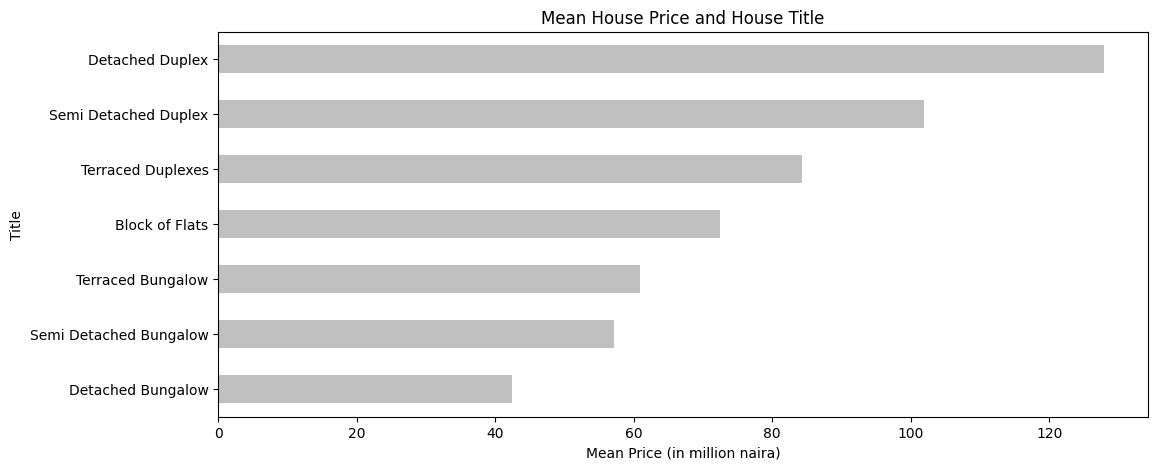

In [47]:
#barplot of house title and mean house price

(((df_dup.groupby("title")["price"].mean())/1e6).sort_values()
 .plot.barh(xlabel="Mean Price (in million naira)", ylabel="Title", color="silver",
            title="Mean House Price and House Title"));

The average housing price vary significantly across the levels of house titles. `Detached Duplex` is expected to be about 3 times as expensive as a `Detached Bungalow` on the average, keeping other factors constant.

## Predicting Lagos state House Price

In [48]:
# Extract Lagos state records

lagos_df = df_dup[df_dup["state"] == "Lagos"].drop(columns="state")
print(lagos_df.shape)
lagos_df.head()

(7002, 7)


,bedrooms,bathrooms,toilets,parking_space,title,town,price
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,75000000.0
6,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,65000000.0
8,1.0,1.0,1.0,1.0,Detached Duplex,Lekki,200000000.0


#### Merging towns with fewer record
Lets categorize towns with records less than 20 as `Others`

In [49]:
#20 towns in Lagos with the least records
lagos_df["town"].value_counts().sort_values(ascending=False)

town
Lekki                   3115
Ajah                    1115
Ikeja                    465
Ikoyi                    300
Ibeju Lekki              283
Victoria Island (VI)     250
Magodo                   246
Isheri North             143
Surulere                 115
Ikorodu                  106
Isolo                     89
Alimosho                  85
Yaba                      78
Agege                     77
Ojodu                     61
Maryland                  59
Gbagada                   52
Ikotun                    48
Ipaja                     45
Ogudu                     39
Amuwo Odofin              37
Ifako-Ijaiye              31
Ilupeju                   29
Ojo                       28
Isheri                    15
Ketu                      14
Shomolu                   12
Oshodi                    11
Ejigbo                     9
Ayobo                      7
Idimu                      7
Apapa                      6
Lagos Island               4
Badagry                    4
Kosofe   

Lets write a function that takes towns with less than 20 records and categorize them as `Others`

In [50]:
def categorize_as_other(state, state_df):
    # get the counts of each town

    state_count = state_df["town"].value_counts()

    # get towns less than 20
    less_than_20_town = state_count[state_count < 20].index.to_list()
    dict_less_than_20_town = {town: f"Others_{state.lower()}" for town in less_than_20_town}

    # replacing each town with Others
    state_df.loc[:,"town"] = state_df["town"].replace(dict_less_than_20_town)

    return state_df

In [51]:
#Categorizing towns with less than 20 records as Others
lagos_df = categorize_as_other("lagos", lagos_df)
lagos_df["town"].unique()

array(['Lekki', 'Ajah', 'Victoria Island (VI)', 'Ikeja', 'Magodo', 'Yaba',
       'Agege', 'Ikorodu', 'Isheri North', 'Others_lagos', 'Ikoyi',
       'Ipaja', 'Ibeju Lekki', 'Ojodu', 'Ogudu', 'Isolo', 'Surulere',
       'Alimosho', 'Ikotun', 'Maryland', 'Gbagada', 'Ifako-Ijaiye', 'Ojo',
       'Ilupeju', 'Amuwo Odofin'], dtype=object)

## Modeling Lagos House Price

#### Splitting data into training and test sets

In [52]:
X_lag, y_lag = lagos_df.drop(columns="price"), lagos_df["price"]

X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(X_lag, y_lag, test_size=0.2, random_state=42)

#### Baseline Model

In [53]:
y_pred_base_lag = [y_train_lag.mean()] * len(y_train_lag)

print(f"Baseline R-square: {r2_score(y_train_lag, y_pred_base_lag)}")
print(f"Baseline Model MAE (training): N{mean_absolute_error(y_train_lag, y_pred_base_lag):,.2f}")
print(f"Baseline Model MAE (test): N{mean_absolute_error(y_test_lag, [y_train_lag.mean()] * len(y_test_lag)):,.2f}")

Baseline R-square: 0.0
Baseline Model MAE (training): N63,224,411.33
Baseline Model MAE (test): N62,446,747.51


We now build our regression model that can better the`Baseline Model`

#### Model Selection: GridSearchCV

Define a reuseable function call `grid_search_cv` to help with the grid search.

In [54]:
# define function for grid search

def grid_search_cv(X_train, X_test, y_train, y_test):

    models_dict = {
                    "Ridge": {
                        "params": { "ridge__alpha": [1e-5, 1e-2, 1e-1, 1, 5, 10]},
                        "estimator": make_pipeline(OneHotEncoder(), Ridge(random_state=42))
                    },
                    "DecisionTreeRegressor":{
                        "params":{"decisiontreeregressor__max_depth": [2, 4, 10, 20] },
                        "estimator": make_pipeline(OrdinalEncoder(), DecisionTreeRegressor(random_state=42))
                    },
                        "RandomForestRegressor":{
                        "params": {"randomforestregressor__max_depth": [2, 4, 10, 50],
                                "randomforestregressor__n_estimators": [5, 20, 50, 100, 200]},
                        "estimator": make_pipeline(OrdinalEncoder(), RandomForestRegressor(random_state=42, n_jobs=-1))
                    },
                        "GradientBoostingRegressor":{
                        "params":{"gradientboostingregressor__max_depth": [2, 4, 10, 50],
                                "gradientboostingregressor__alpha": [1e-10, 1e-2, 0.5, 0.9],
                                "gradientboostingregressor__n_estimators": [5, 20, 50, 100, 200]},
                        "estimator": make_pipeline(OrdinalEncoder(), GradientBoostingRegressor(random_state=42))
                    },
                    "SVR": {
                        "params": {
                            "svr__kernel": ["linear", "poly", "rbf", "sigmoid"]},
                            "estimator": make_pipeline(OrdinalEncoder(), SVR())
                    },
                    "KNeighborsRegressor": {
                        "params": {
                            "kneighborsregressor__n_neighbors": [3, 5, 7, 10, 15, 30],
                            "kneighborsregressor__weights": ["uniform", "distance"]},
                            "estimator": make_pipeline(OneHotEncoder(), KNeighborsRegressor())
                    }
                }


    model_eval_dict = {"model_name":[], "best_parameter":[], "train_mae":[], "test_mae":[], "r_square":[]}

    for each_model in models_dict:
        each_model_dict = models_dict[each_model]
        params = each_model_dict["params"]
        estimator=each_model_dict["estimator"]
        model_lag = GridSearchCV(param_grid=params, estimator=estimator, cv=5, scoring="neg_mean_absolute_error")
        model_lag.fit(X_train, y_train)

        test_mae = mean_absolute_error(y_test, model_lag.predict(X_test)).astype(int)

        model_eval_dict["model_name"].append(each_model)
        model_eval_dict["best_parameter"].append(model_lag.best_params_)
        model_eval_dict["train_mae"].append(np.abs(model_lag.best_score_).astype(int))
        model_eval_dict["test_mae"].append(test_mae)
        model_eval_dict["r_square"].append(r2_score(y_train, model_lag.predict(X_train)))

    model_eval_df = pd.DataFrame(model_eval_dict).set_index("model_name")


    return model_eval_df

In [55]:
model_eval_df_lag = grid_search_cv(X_train_lag, X_test_lag, y_train_lag, y_test_lag)
model_eval_df_lag

,best_parameter,train_mae,test_mae,r_square
model_name,,,,
Ridge,{'ridge__alpha': 5},40759041,41701145,0.506908
DecisionTreeRegressor,{'decisiontreeregressor__max_depth': 10},40489205,40586661,0.576903
RandomForestRegressor,"{'randomforestregressor__max_depth': 10, 'rand...",39463313,40086722,0.598132
GradientBoostingRegressor,"{'gradientboostingregressor__alpha': 1e-10, 'g...",38812872,39432943,0.583495
SVR,{'svr__kernel': 'linear'},59131276,57615929,-0.120524
KNeighborsRegressor,"{'kneighborsregressor__n_neighbors': 10, 'knei...",44616043,43588118,0.657766


All the regression models did well compared to the `baseline model`. However, `SVR` did poorly compared to other models. `GradientBoostingRegressor` fits the `lagos_df` well compared to other models since it has the least `mae`.

In [56]:
#Selecting parameters of the model with the least test mae: model that generalized well with unseen records
model_eval_df_lag[model_eval_df_lag.test_mae == model_eval_df_lag.test_mae.min()]["best_parameter"].iloc[0]

{'gradientboostingregressor__alpha': 1e-10,
 'gradientboostingregressor__max_depth': 4,
 'gradientboostingregressor__n_estimators': 200}

In [75]:
from sklearn.preprocessing import StandardScaler
# fitting our model with the best parameters
final_model_lag = make_pipeline(
    OrdinalEncoder(),               # Encoding categorical features
    StandardScaler(),               # Scaling the features
    GradientBoostingRegressor(random_state=42, alpha=1e-10, max_depth=4, n_estimators=200)
)
final_model_lag.fit(X_train_lag, y_train_lag)

print(f"Ridge R-square Train: {r2_score(y_train_lag, final_model_lag.predict(X_train_lag)):,.2f}")
print(f"Ridge R-square Test: {r2_score(y_test_lag, final_model_lag.predict(X_test_lag)):,.2f}")
print(f"Ridge Model MAE (training): N{mean_absolute_error(y_train_lag, final_model_lag.predict(X_train_lag)):,.2f}")
print(f"Ridge Model MAE (test): N{mean_absolute_error(y_test_lag, final_model_lag.predict(X_test_lag)):,.2f}")

Ridge R-square Train: 0.58
Ridge R-square Test: 0.48
Ridge Model MAE (training): N35,673,206.30
Ridge Model MAE (test): N39,442,863.82


In [58]:
# define a function that graphs the actual price versus the predicted and also the top n errors

def actual_pred_graph (state_name:str, X_train, X_test, y_test, y_train, model, number_of_error = 20):
    y_pred_test = pd.Series(model.predict(X_test), index=y_test.index)
    error_test = np.abs(y_test - y_pred_test)

    y_pred_train = pd.Series(model.predict(X_train), index=y_train.index)
    error_train = np.abs(y_train - y_pred_train)

    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, model.predict(X_test))

    if number_of_error > 1 and number_of_error < len(y_test):

        index_top_n_errors_test = np.argsort(error_test).iloc[-number_of_error:].to_list()
        index_top_n_errors_train = np.argsort(error_train).iloc[-number_of_error:].to_list()

        top_n_error_lag_test = pd.DataFrame(X_test.iloc[index_top_n_errors_test, :]) #to avoid flagging loc error
        top_n_error_lag_test.loc[:,"price"] = y_test.iloc[index_top_n_errors_test]
        top_n_error_lag_test.loc[:,"predict"] = y_pred_test.iloc[index_top_n_errors_test].astype(int)
        top_n_error_lag_test.loc[:,"abs_error"] = error_test.iloc[index_top_n_errors_test].astype(int)

        top_n_error_lag_train = pd.DataFrame(X_train.iloc[index_top_n_errors_train, :]) #to avoid flagging loc error
        top_n_error_lag_train.loc[:,"price"] = y_train.iloc[index_top_n_errors_train]
        top_n_error_lag_train.loc[:,"predict"] = y_pred_train.iloc[index_top_n_errors_train].astype(int)
        top_n_error_lag_train.loc[:,"abs_error"] = error_train.iloc[index_top_n_errors_train].astype(int)

        plt.figure(figsize=(12,6))

        plt.subplot(1,2,1)
        plt.scatter(x=y_test/1e6, y=y_pred_test/1e6, alpha=0.6, c="silver", label=f"R_square={test_r2.round(2)}")
        plt.scatter(x=top_n_error_lag_test.price/1e6, y=top_n_error_lag_test.predict/1e6, c="black",
                    marker="X", alpha=0.4, label=f"Top {number_of_error} Abs Errors")
        plt.plot([0,y_test.max()/1e6], [0,y_test.max()/1e6], ls="--", color="dimgray", alpha=0.5, label="Fitted Linear Model")
        plt.xlabel(f"{state_name} Actual House Price")
        plt.ylabel("Predicted House Price")
        plt.legend()
        plt.title(f"{state_name} (Test set): Actual Price vs Predicted Price")

        plt.subplot(1,2,2)
        plt.scatter(x=y_train/1e6, y=y_pred_train/1e6, alpha=0.6, c="silver", label=f"R_square={train_r2.round(2)}")
        plt.scatter(x=top_n_error_lag_train.price/1e6, y=top_n_error_lag_train.predict/1e6, c="black",
                    marker="X", alpha=0.4, label=f"Top {number_of_error} Abs Errors")
        plt.plot([0,y_train.max()/1e6], [0,y_train.max()/1e6], ls="--", color="dimgray", alpha=0.5, label="Fitted Linear Model")
        plt.xlabel("Actual House Price")
        plt.ylabel("Predicted House Price")
        plt.legend()
        plt.title(f"{state_name} (Train set): Actual Price vs Predicted Price")
        plt.tight_layout();

    else:
        plt.figure(figsize=(12,6))

        plt.subplot(1,2,1)
        plt.scatter(x=y_test/1e6, y=y_pred_test/1e6, alpha=0.6, c="silver", label=f"R_square={test_r2.round(2)}")
        plt.plot([0,y_test.max()/1e6], [0,y_test.max()/1e6], ls="--", color="dimgray", alpha=0.5, label="Fitted Linear Model")
        plt.xlabel(f"{state_name} Actual House Price")
        plt.ylabel("Predicted House Price")
        plt.legend()
        plt.title(f"{state_name} (Test set): Actual Price vs Predicted Price")

        plt.subplot(1,2,2)
        plt.scatter(x=y_train/1e6, y=y_pred_train/1e6, alpha=0.6, c="silver", label=f"R_square={train_r2.round(2)}")
        plt.plot([0,y_train.max()/1e6], [0,y_train.max()/1e6], ls="--", color="dimgray", alpha=0.5, label="Fitted Linear Model")
        plt.xlabel("Actual House Price")
        plt.ylabel("Predicted House Price")
        plt.legend()
        plt.title(f"{state_name} (Train set): Actual Price vs Predicted Price")
        plt.tight_layout();

## Predicting Abuja FCT House Price

In [59]:
# Extract Abuja records

abuja_df = df_dup[df_dup["state"] == "Abuja"].drop(columns="state")
print(abuja_df.shape)
abuja_df.head()

(2529, 7)


,bedrooms,bathrooms,toilets,parking_space,title,town,price
10,3.0,4.0,5.0,4.0,Terraced Duplexes,Lokogoma District,25000000.0
17,3.0,3.0,4.0,4.0,Detached Bungalow,Lokogoma District,37000000.0
23,5.0,6.0,7.0,6.0,Detached Duplex,Katampe,160000000.0
34,5.0,5.0,6.0,6.0,Detached Duplex,Kaura,150000000.0
35,4.0,4.0,5.0,8.0,Detached Duplex,Galadimawa,70000000.0


In [60]:
#Categorizing towns with less than 20 records as Others
abuja_df = categorize_as_other("abuja", abuja_df)
abuja_df["town"].unique()

array(['Lokogoma District', 'Katampe', 'Kaura', 'Galadimawa', 'Gwarinpa',
       'Lugbe District', 'Jahi', 'Others_abuja', 'Guzape District',
       'Utako', 'Life Camp', 'Gaduwa', 'Asokoro District', 'Wuye',
       'Kubwa', 'Apo', 'Wuse 2', 'Durumi', 'Mabushi', 'Karsana', 'Wuse',
       'Karmo', 'Maitama District', 'Gudu', 'Mbora (Nbora)', 'Jabi',
       'Garki', 'Kado'], dtype=object)

## Modeling Abuja House Price

#### Splitting data into training and test sets

In [61]:
X_abj, y_abj = abuja_df.drop(columns="price"), abuja_df["price"]

X_train_abj, X_test_abj, y_train_abj, y_test_abj = train_test_split(X_abj, y_abj, test_size=0.2, random_state=42)

#### Baseline Model

In [62]:
y_pred_base_abj = [y_train_abj.mean()] * len(y_train_abj)

print(f"Baseline R-square: {r2_score(y_train_abj, y_pred_base_abj)}")
print(f"Baseline Model MAE (training): N{mean_absolute_error(y_train_abj, y_pred_base_abj):,.2f}")
print(f"Baseline Model MAE (test): N{mean_absolute_error(y_test_abj, [y_train_abj.mean()] * len(y_test_abj)):,.2f}")

Baseline R-square: 0.0
Baseline Model MAE (training): N60,041,228.35
Baseline Model MAE (test): N59,813,403.72


#### Model Selection: GridSearchCV

In [63]:
model_eval_df_abj = grid_search_cv(X_train_abj, X_test_abj, y_train_abj, y_test_abj)
model_eval_df_abj

,best_parameter,train_mae,test_mae,r_square
model_name,,,,
Ridge,{'ridge__alpha': 5},37739289,38540943,0.537003
DecisionTreeRegressor,{'decisiontreeregressor__max_depth': 10},39126053,42900156,0.665895
RandomForestRegressor,"{'randomforestregressor__max_depth': 10, 'rand...",36093128,38113170,0.724051
GradientBoostingRegressor,"{'gradientboostingregressor__alpha': 1e-10, 'g...",35440115,36861465,0.702845
SVR,{'svr__kernel': 'linear'},55720262,54581544,-0.130410
KNeighborsRegressor,"{'kneighborsregressor__n_neighbors': 10, 'knei...",42002225,43282895,0.858386


Also for the `abuja_df`, the `GradientBoostingRegressor` performed well compared to other regression models.

In [64]:
#Selecting parameters of the model with the least test mae: model that generalized well with unseen records
model_eval_df_abj[model_eval_df_abj.test_mae == model_eval_df_abj.test_mae.min()]["best_parameter"].iloc[0]

{'gradientboostingregressor__alpha': 1e-10,
 'gradientboostingregressor__max_depth': 4,
 'gradientboostingregressor__n_estimators': 200}

In [79]:
# fitting our model with the best parameters
final_model_abj = make_pipeline(OrdinalEncoder(),               # Encoding categorical features
    StandardScaler(),               # Scaling the features
    GradientBoostingRegressor(random_state=42, alpha=1e-10, max_depth=4, n_estimators=200))
final_model_abj.fit(X_train_abj, y_train_abj)

print(f"Ridge R-square: {r2_score(y_train_abj, final_model_abj.predict(X_train_abj)):,.2f}")
print(f"Ridge Model MAE (training): N{mean_absolute_error(y_train_abj, final_model_abj.predict(X_train_abj)):,.2f}")
print(f"Ridge Model MAE (test): N{mean_absolute_error(y_test_abj, final_model_abj.predict(X_test_abj)):,.2f}")

Ridge R-square: 0.70
Ridge Model MAE (training): N27,760,527.92
Ridge Model MAE (test): N36,885,676.26


### Function to Predict Housing Price in Lagos and Abuja

In [ ]:
def prediction_fun(state:str = "Lagos", bedrooms:int = 1, bathrooms:int = 1, toilets:int = 1,
                      parking_space:int = 1, title:str = "Detached Duplex", town:str="Ikoyi"):

    if state.capitalize() == "Lagos":
        if town in list(lagos_df["town"].unique()) and title in list(lagos_df["title"].unique()) :
            X = pd.DataFrame({"bedrooms":bedrooms, "bathrooms":bathrooms, "toilets":toilets,
                              "parking_space":parking_space, "title":title, "town":town}, index=[0])
            y_pred = final_model_lag.predict(X)[0]
            print(f"The price of a {title} with {bedrooms} bedroom(s), {bathrooms} bathroom(s), and {parking_space} parking space(s) in {town}, {state.capitalize()} is {y_pred:,.2f}")

        else:
            print(f"""
                  Prediction Error!

                  - Check if title ({title}) is in:
                  {lagos_df.title.unique()} and/or

                  - Check if the town ({town}) is in {state} towns:
                  {lagos_df.town.unique()}
                  """
                  )

    elif state.capitalize() == "Abuja":
        if town in list(abuja_df["town"].unique()) and title in list(abuja_df["title"].unique()) :
            X = pd.DataFrame({"bedrooms":bedrooms, "bathrooms":bathrooms, "toilets":toilets,
                              "parking_space":parking_space, "title":title, "town":town}, index=[0])
            y_pred = final_model_abj.predict(X)[0]
            print(f"The price of a {title} with {bedrooms} bedroom(s), {bathrooms} bathroom(s), and {parking_space} parking space(s) in {town}, {state.capitalize()} is {y_pred:,.2f}")

        else:
            print(f"""
                  Prediction Error!

                  - Check if title ({title}) is in:
                  {abuja_df.title.unique()} and/or

                  - Check if the town ({town}) is in {state} towns:
                  {abuja_df.town.unique()}
                  """
                  )
    else:
        print(f"Invalid state name: \"{state}.\" State should either be 'Lagos' or 'Abuja'")


In [ ]:
prediction_fun( state="abuja", town='Katampe')

In [81]:
input_features = [[4.0,	5.0, 5.0, 4.0, "Detached Duplex", "Lekki"]]

final_model_lag.predict(input_features)


array([1.03342376e+08])

In [80]:
import joblib

# saving the models
# Save the Lagos model
joblib.dump(final_model_lag, 'final_model_lag.joblib')

# Save the Abuja model
joblib.dump(final_model_abj, 'final_model_abj.joblib')

['final_model_abj.joblib']